## Downloading all the libraries that we will need

In [ ]:
! pip install ultralytics
! pip install pycocotools
! pip install kaggle

## Importing all the libraries that we will need

In [ ]:
import pycocotools
from ultralytics import YOLO
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import os
import yaml
import torch
import shutil
import glob
%matplotlib inline

## Saving the main directories in variables for ease of access

In [ ]:
train_imgs_dir="/content/car-object-detection/data/training_images"
train_labels="/content/car-object-detection/data/train_solution_bounding_boxes (1).csv"
test_imgs_dir="/content/car-object-detection/data/testing_images"

## Downloading the dataset from kaggle onto google collab directly and unzipping it

In [ ]:
from google.colab import files
files.upload()

!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json


In [ ]:
!kaggle datasets download -d sshikamaru/car-object-detection

 87% 97.0M/112M [00:01<00:00, 79.1MB/s]
100% 112M/112M [00:01<00:00, 93.9MB/s] 


In [ ]:
import zipfile

with zipfile.ZipFile('car-object-detection.zip', 'r') as zip_ref:
    zip_ref.extractall('car-object-detection')

## Randomly shuffling the dataset and splitting the training into 80% training and 20% validation

In [ ]:
imgs_list=list(sorted(os.listdir(train_imgs_dir)))
idxs=list(range(len(imgs_list)))
np.random.shuffle(idxs)

train_idx=idxs[:int(0.8*len(idxs))]
val_idx=idxs[int(0.8*len(idxs)):]

## Converting the dataset into a format acceptable by YOLO

Creating the new directory for the yolo format dataset

In [ ]:
# root directory
!mkdir "datasets"
!mkdir "datasets/working"
!mkdir "datasets/working/data"

# images directory
!mkdir "datasets/working/data/images"

# train and test subdirectories with image directory
!mkdir "datasets/working/data/images/train"
!mkdir "datasets/working/data/images/val"

# labels directory
!mkdir "datasets/working/data/labels"

# train and test subdirectories with labels directory
!mkdir "datasets/working/data/labels/train"
!mkdir "datasets/working/data/labels/val"

Saving the new directories in variables for ease of access

In [ ]:
root_dir="datasets/working/data"
labels_dir="datasets/working/data/labels"
images_dir="datasets/working/data/images"

In [ ]:
df=pd.read_csv(train_labels)

width=676
height=380

df["class"]=0
df.rename(columns={'image':'img_name'}, inplace=True)

df["x_centre"]=(df["xmin"]+df["xmax"])/2
df["y_centre"]=(df["ymin"]+df["ymax"])/2
df["width"]=(df["xmax"]-df["xmin"])
df["height"]=(df["ymax"]-df["ymin"])

#normalizing bounding box coordinates
df["x_centre"]=df["x_centre"]/width
df["y_centre"]=df["y_centre"]/height
df["width"]=df["width"]/width
df["height"]=df["height"]/height

df_yolo=df[["img_name","class","x_centre","y_centre","width","height"]]
df_yolo.head()

,img_name,class,x_centre,y_centre,width,height
0,vid_4_1000.jpg,0,0.450434,0.539817,0.068741,0.095238
1,vid_4_10000.jpg,0,0.100217,0.557191,0.155572,0.129987
2,vid_4_10040.jpg,0,0.444645,0.543678,0.181621,0.157014
3,vid_4_10020.jpg,0,0.833213,0.531451,0.197540,0.155727
4,vid_4_10060.jpg,0,0.110347,0.559122,0.171491,0.136422


In [ ]:
for idx,img_name in enumerate(imgs_list):
    subset="train"
    if idx in val_idx:
        subset="val"

    if np.isin(img_name,df_yolo["img_name"]):
        columns=["class","x_centre","y_centre","width","height"]
        img_bbox=df_yolo[df_yolo["img_name"]==img_name][columns].values

        label_file_path=os.path.join(labels_dir,subset,img_name[:-4]+".txt")
        with open(label_file_path,"w+") as f:
            for row in img_bbox:
                text=" ".join(row.astype(str))
                f.write(text)
                f.write("\n")

    old_image_path=os.path.join(train_imgs_dir,img_name)
    new_image_path=os.path.join(images_dir,subset,img_name)
    shutil.copy(old_image_path,new_image_path)

saving the output in a .yaml file

In [ ]:
yolo_format=dict(path="/content/datasets/working/data",
                 train="/content/datasets/working/data/images/train",
                 val="/content/datasets/working/data/images/val",
                 nc=1,
                 names={0:"car"})

with open('/content/datasets/working/yolo.yaml', 'w') as outfile:
    yaml.dump(yolo_format, outfile, default_flow_style=False)

## Training the model

In [ ]:
model=YOLO('yolov8m.pt')
model.train(data="datasets/working/yolo.yaml",epochs=50,patience=5,batch=8,lr0=0.0005,imgsz=640)

100%|██████████| 49.7M/49.7M [00:00<00:00, 55.3MB/s]
Ultralytics YOLOv8.0.162 🚀 Python-3.10.12 torch-2.0.1+cu118 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=yolov8m.pt, data=datasets/working/yolo.yaml, epochs=50, patience=5, batch=8, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=None, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, show=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, vid_stride=1, line_width=None, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, boxes=True, format=t

## Evaluating the best run of the model

In [ ]:
path_best_weights="/content/runs/detect/train/weights/best.pt"
model = YOLO(path_best_weights)
metrics = model.val()

Ultralytics YOLOv8.0.162 🚀 Python-3.10.12 torch-2.0.1+cu118 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 218 layers, 25840339 parameters, 0 gradients
val: Scanning /content/datasets/working/data/labels/val.cache... 76 images, 125 backgrounds, 0 corrupt: 100%|██████████| 201/201 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:06<00:00,  2.13it/s]
                   all        201        113      0.982      0.959      0.992      0.684
Speed: 1.5ms preprocess, 13.5ms inference, 0.0ms loss, 1.6ms postprocess per image
Results saved to runs/detect/val


In [ ]:
print(f"Mean Average Precision @.5:.95 : {metrics.box.map}")
print(f"Mean Average Precision @ .50   : {metrics.box.map50}")
print(f"Mean Average Precision @ .70   : {metrics.box.map75}")

Mean Average Precision @.5:.95 : 0.684492508638687
Mean Average Precision @ .50   : 0.9916925979184019
Mean Average Precision @ .70   : 0.8400432426164479


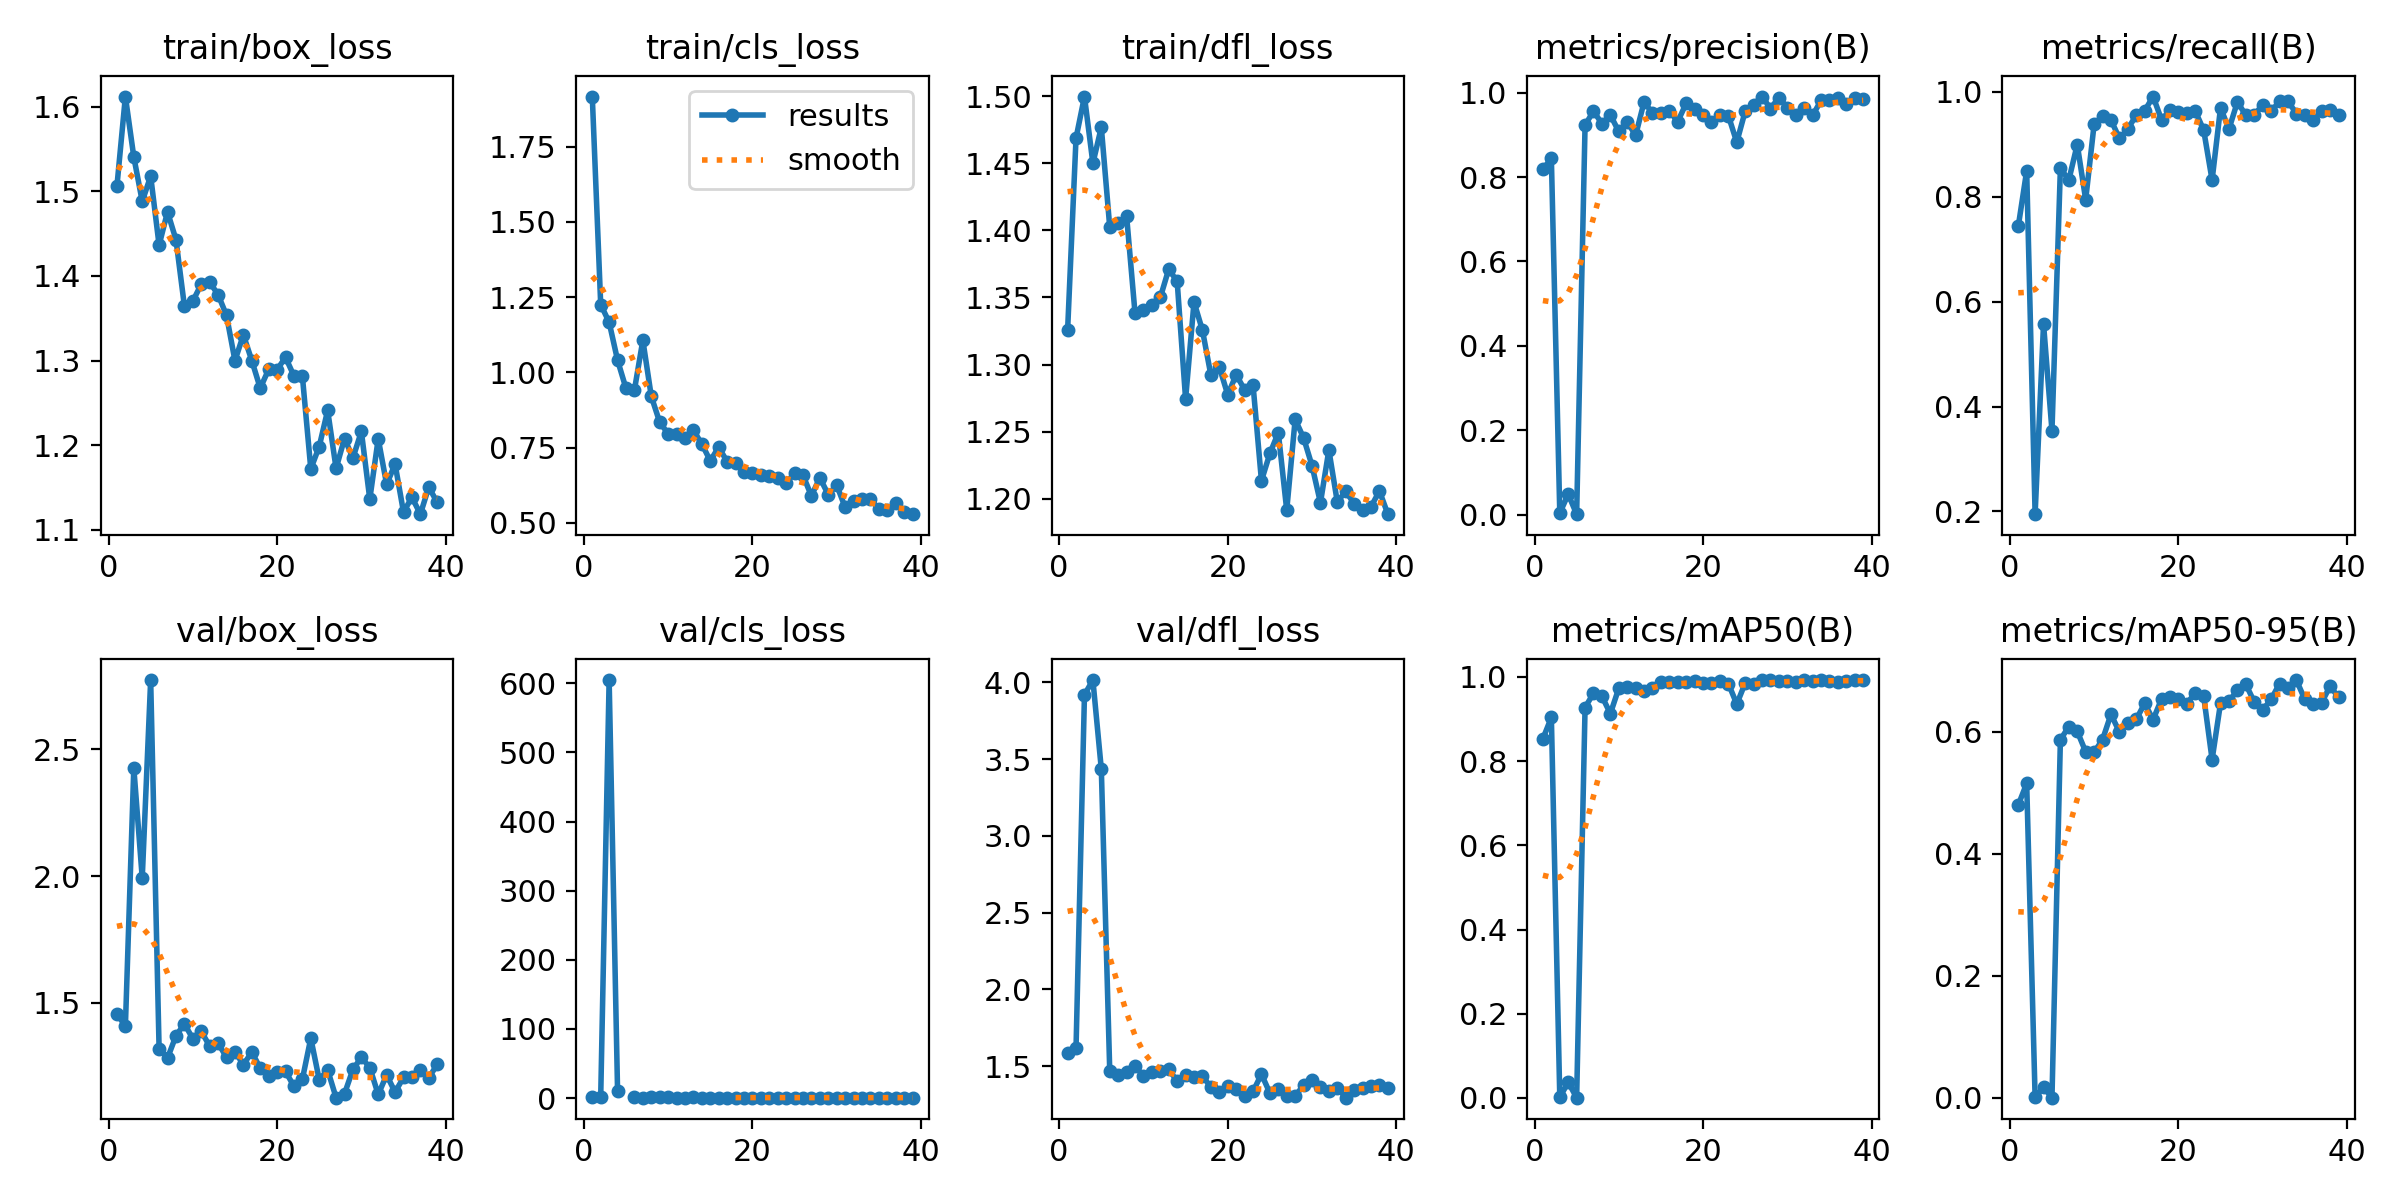

In [ ]:
# Plot the training and validation loss curves
from IPython.display import Image, display
Image("/content/runs/detect/train/results.png")

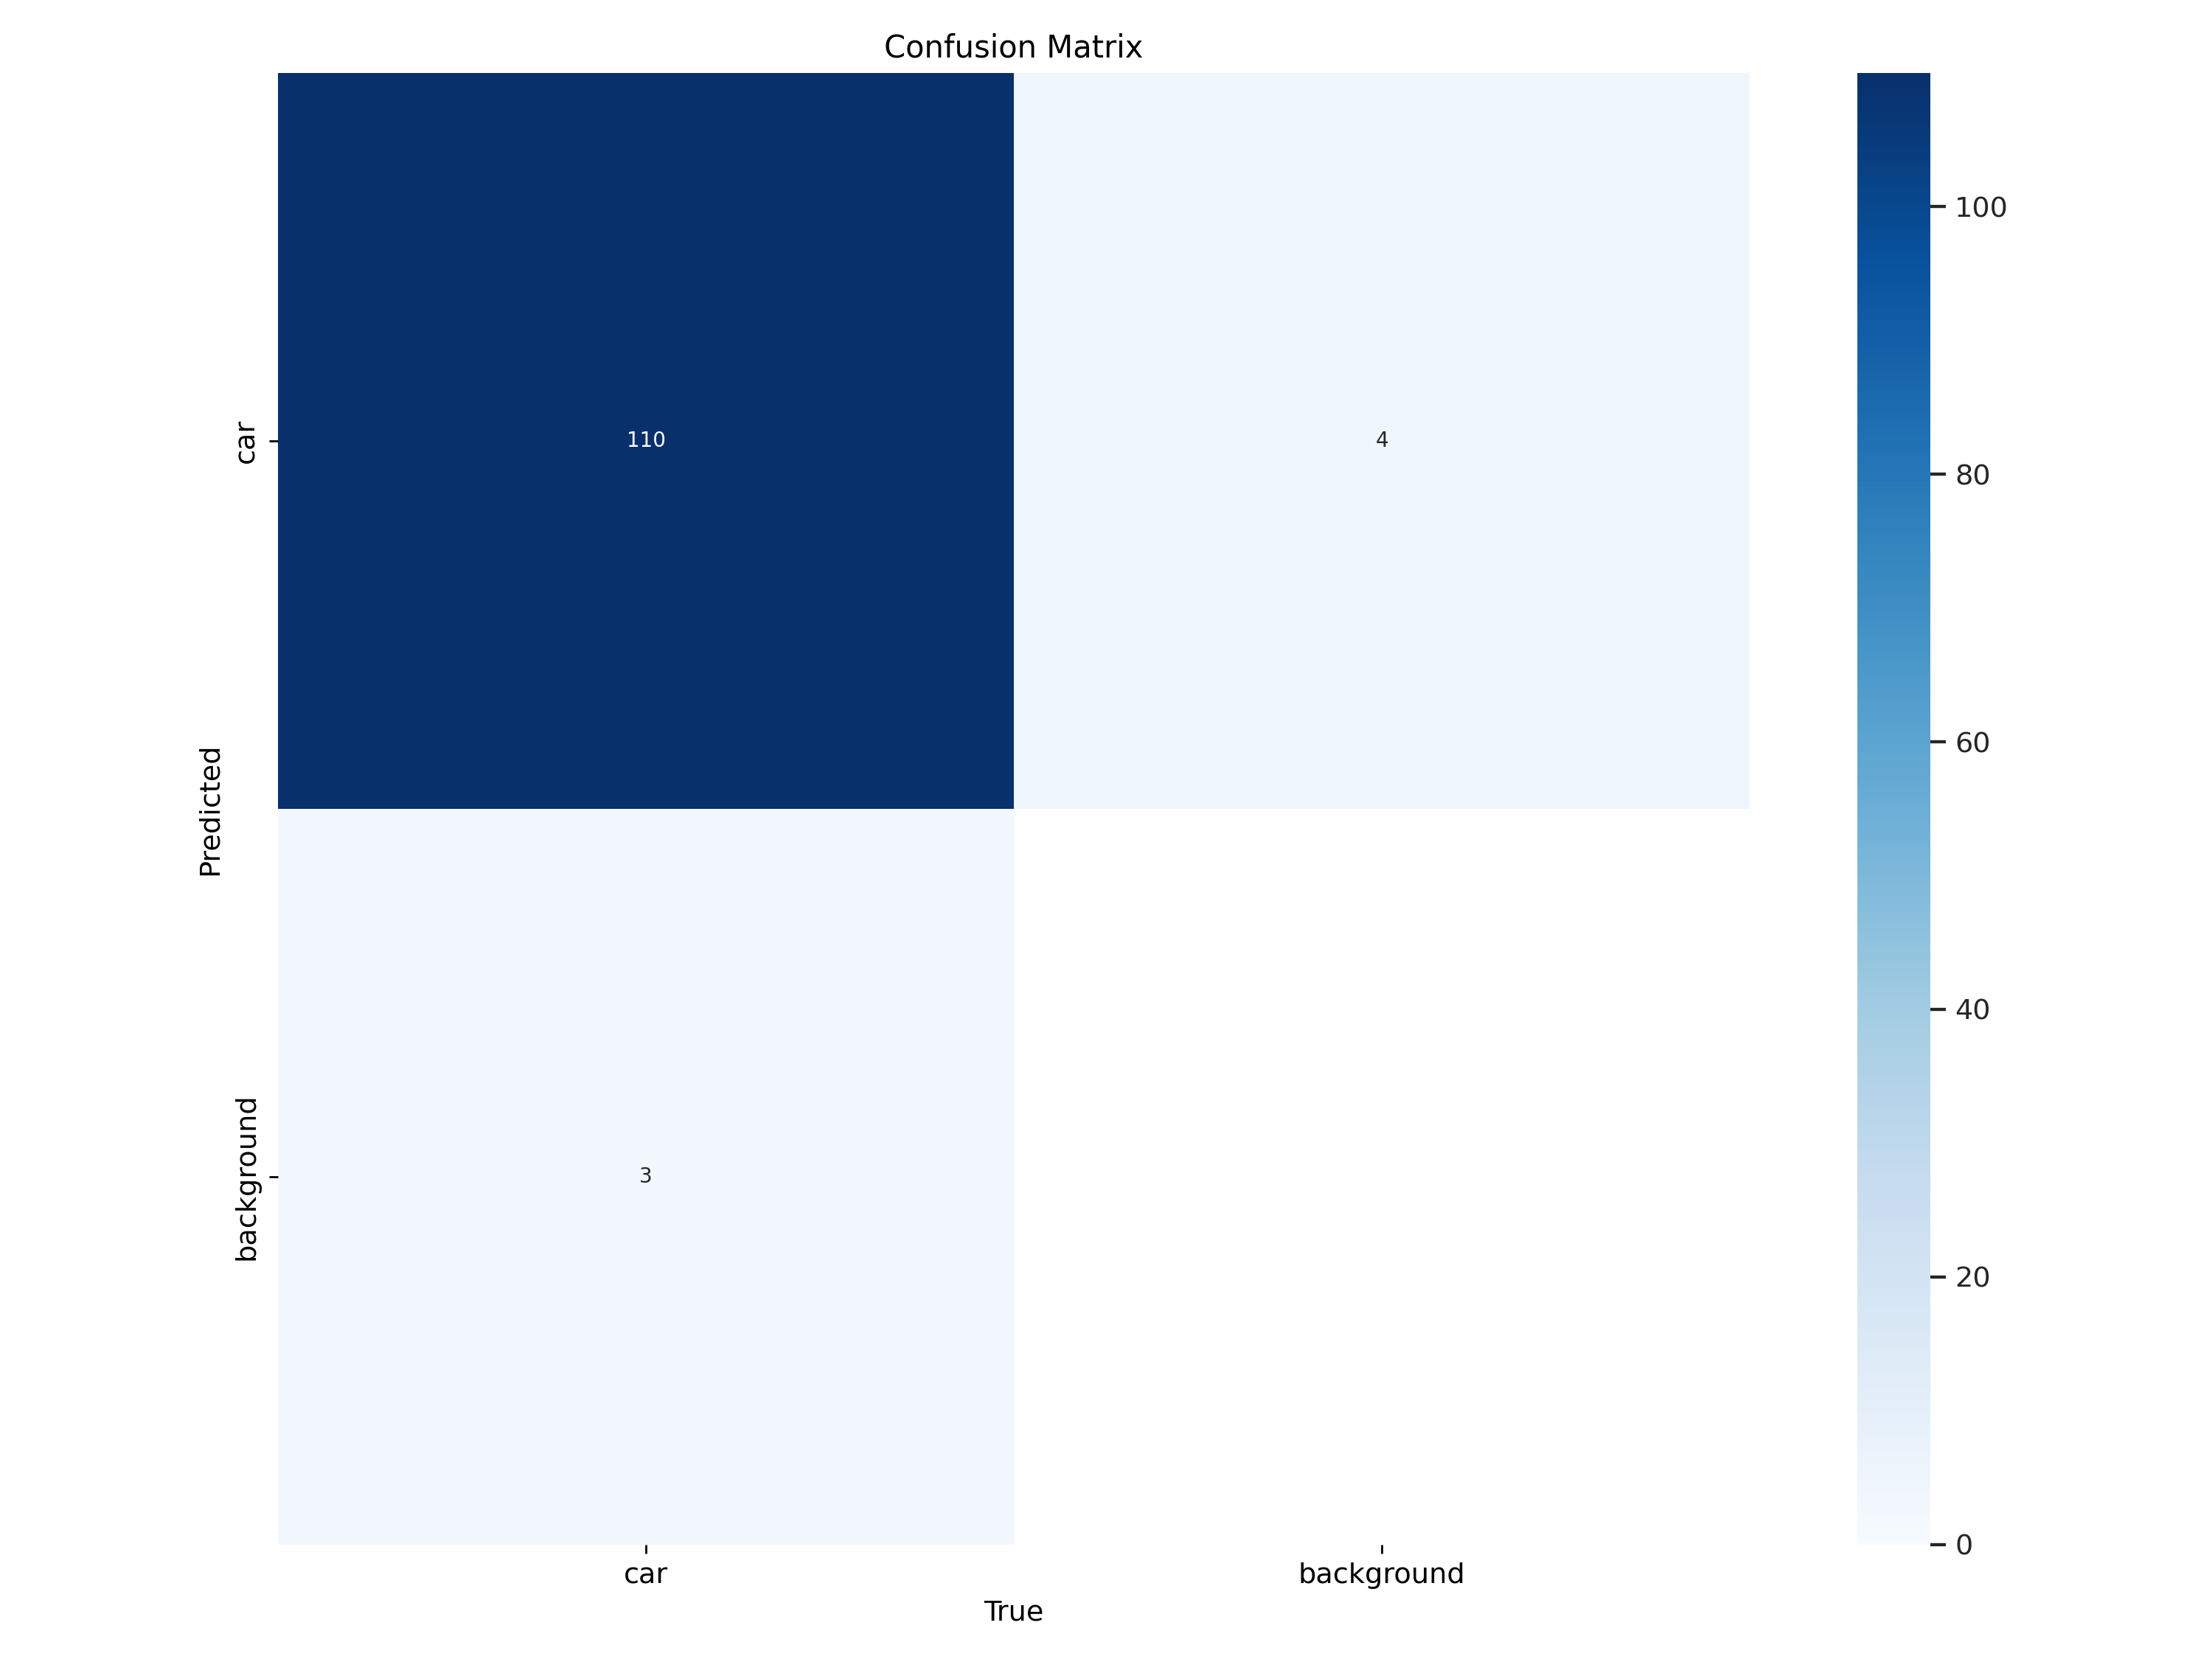

In [ ]:
# Plot the confusion matrix
Image("/content/runs/detect/train/confusion_matrix.png")

## Testing the best run of the model with the testing dataset and displaying some of the results

In [ ]:
model = YOLO("/content/runs/detect/train/weights/best.pt")
ret = model(test_imgs_dir,save=True, conf=0.2, iou=0.5)


image 1/175 /content/car-object-detection/data/testing_images/vid_5_25100.jpg: 384x640 (no detections), 231.2ms
image 2/175 /content/car-object-detection/data/testing_images/vid_5_25120.jpg: 384x640 (no detections), 25.8ms
image 3/175 /content/car-object-detection/data/testing_images/vid_5_25140.jpg: 384x640 (no detections), 25.8ms
image 4/175 /content/car-object-detection/data/testing_images/vid_5_25160.jpg: 384x640 (no detections), 27.1ms
image 5/175 /content/car-object-detection/data/testing_images/vid_5_25180.jpg: 384x640 (no detections), 25.8ms
image 6/175 /content/car-object-detection/data/testing_images/vid_5_25200.jpg: 384x640 (no detections), 20.4ms
image 7/175 /content/car-object-detection/data/testing_images/vid_5_25220.jpg: 384x640 (no detections), 20.4ms
image 8/175 /content/car-object-detection/data/testing_images/vid_5_25240.jpg: 384x640 (no detections), 20.4ms
image 9/175 /content/car-object-detection/data/testing_images/vid_5_25260.jpg: 384x640 (no detections), 20.4ms

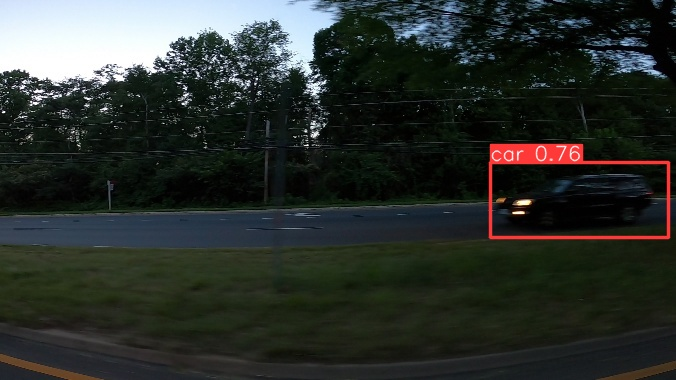

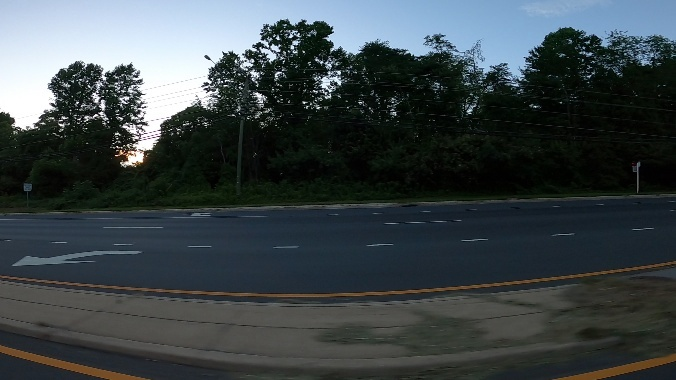

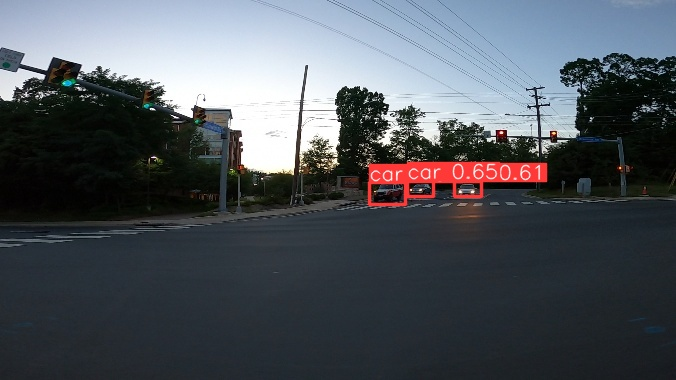

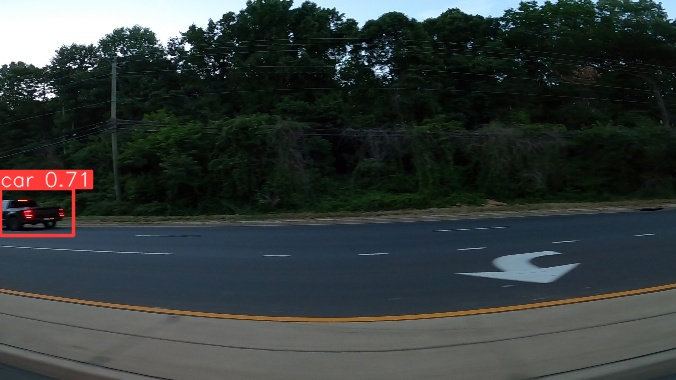

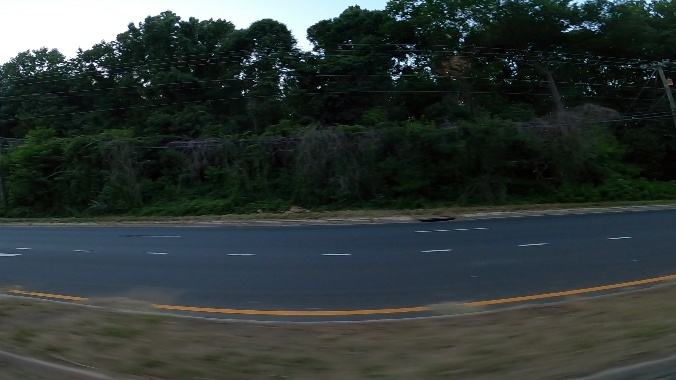

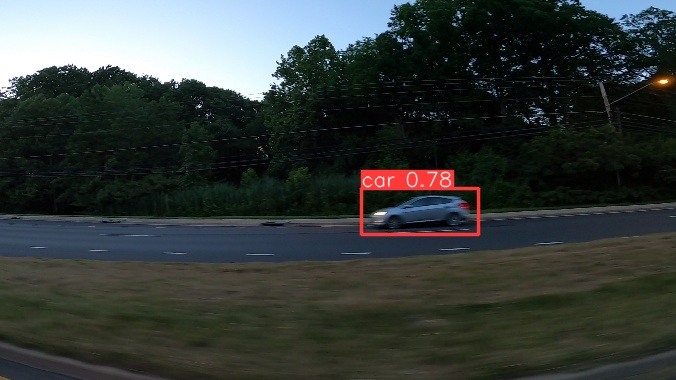

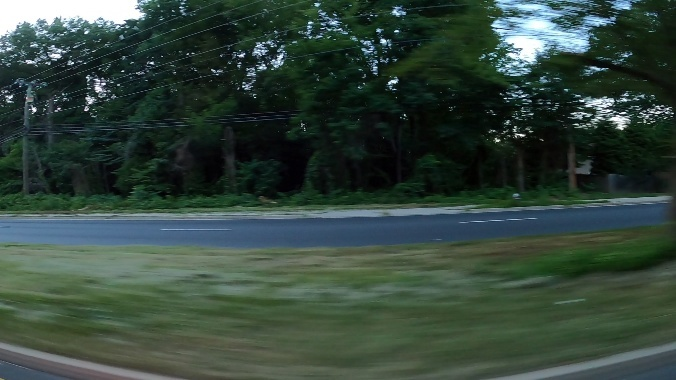

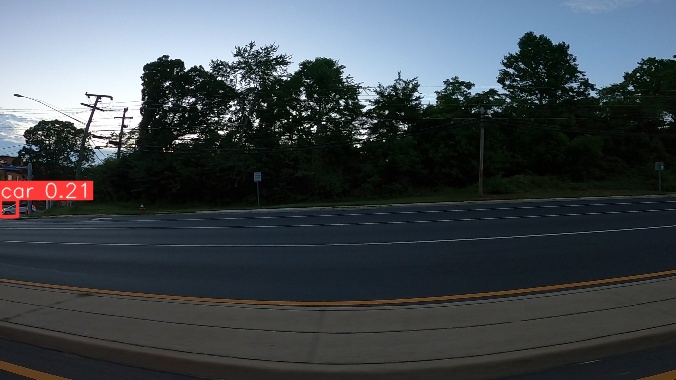

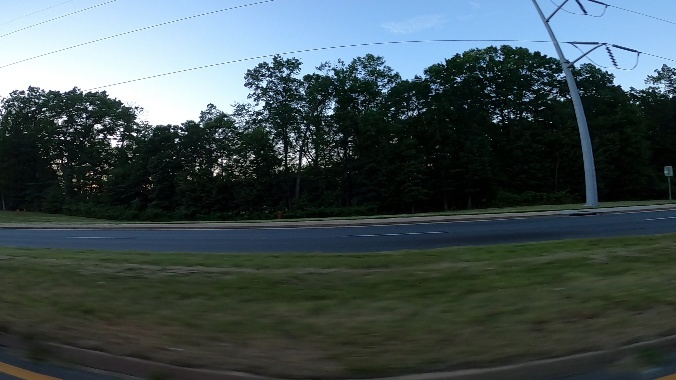

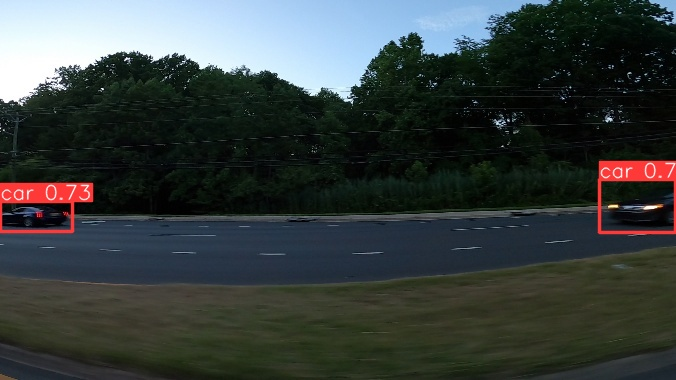

In [ ]:
files = glob.glob("./runs/detect/predict/*")
for i in range(0, 50, 5):
    img = Image(files[i])
    display(img)